In [60]:
#Import the libraries
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [61]:
#Get the data from yahoo finance
stock_ticker = 'FB'


# test = 1 -> time period 2000 to 2020
# test = 0 -> 2021 to now
def get_data(ticker, test):
    if test == 0:
      start = dt.datetime(2021, 1, 1)
      end = dt.datetime.now()
    else:
      start = dt.datetime(2000, 1, 1)
      end = dt.datetime(2020, 12, 31)
    
    df = web.DataReader(ticker,'yahoo', start, end)
    # Create Categorical Input 'Price Change' (Rise = 1, Fall = 0) from previous row Adj Close
    df['Price Change'] = df['Adj Close'].diff()
    df.loc[df['Price Change'] <= 0, 'Price Change'] = 0
    df.loc[df['Price Change'] > 0, 'Price Change'] = 1
    #remove the first row as price change is nan
    df = df[1:]
    return df

df = get_data(stock_ticker,1)
df

,High,Low,Open,Close,Volume,Adj Close,Price Change
Date,,,,,,,
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999,0.0
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000,0.0
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000,1.0
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999,1.0
2012-05-25,32.950001,31.110001,32.900002,31.910000,37149800,31.910000,0.0
...,...,...,...,...,...,...,...
2020-12-24,270.399994,266.200012,268.880005,267.399994,6702000,267.399994,0.0
2020-12-28,277.299988,265.660004,268.739990,277.000000,23299700,277.000000,1.0
2020-12-29,280.510010,276.279999,276.950012,276.779999,16383000,276.779999,0.0


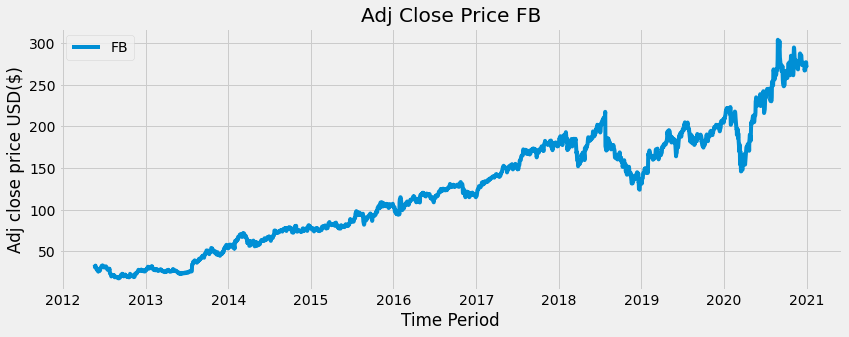

In [62]:
#visualize the data
plt.figure(figsize=(12.5,4.5))
plt.plot(df['Adj Close'], label = stock_ticker)

plt.title('Adj Close Price ' + stock_ticker)
plt.xlabel('Time Period')
plt.ylabel('Adj close price USD($)')
plt.legend(loc = 'upper left')
plt.show()

In [63]:
# Remove all non number
for col in df.columns: 
  df=df[pd.to_numeric(df[col], errors='coerce').notnull()]
# Remove NA
df = df.dropna()

#Preprocess data to fit into LSTM Model

In [64]:
# prepare data for lstm
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values

# ensure all data is float
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[10,9,8,7,11,12]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values
values

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)  var7(t)
1  36.660000  33.000000  36.529999  ...  34.029999        0.0      0.0
2  33.590000  30.940001  32.610001  ...  31.000000        0.0      1.0
3  32.500000  31.360001  31.370001  ...  32.000000        1.0      1.0
4  33.209999  31.770000  32.950001  ...  33.029999        1.0      0.0
5  32.950001  31.110001  32.900002  ...  31.910000        0.0      0.0

[5 rows x 8 columns]


array([[ 36.66,  33.  ,  36.53, ...,  34.03,   0.  ,   0.  ],
       [ 33.59,  30.94,  32.61, ...,  31.  ,   0.  ,   1.  ],
       [ 32.5 ,  31.36,  31.37, ...,  32.  ,   1.  ,   1.  ],
       ...,
       [277.3 , 265.66, 268.74, ..., 277.  ,   1.  ,   0.  ],
       [280.51, 276.28, 276.95, ..., 276.78,   0.  ,   0.  ],
       [278.08, 271.71, 277.95, ..., 271.87,   0.  ,   1.  ]],
      dtype=float32)

In [65]:
# ensure all data is float
values = values.astype('float32')

# split into train and test sets (80% train)
train_size = round(0.8 * len(values))
train = values[:train_size, :]
test = values[train_size:, :]

# split into input and outputs (last column is Y)
train_X, train_y = train[:, :-1], train[:, -1]
print(train_X[:3])
print(train_y[:3])
test_X, test_y = test[:, :-1], test[:, -1]

# preprocess
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X) 

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


[[3.666000e+01 3.300000e+01 3.653000e+01 3.403000e+01 1.681927e+08
  3.403000e+01 0.000000e+00]
 [3.359000e+01 3.094000e+01 3.261000e+01 3.100000e+01 1.017866e+08
  3.100000e+01 0.000000e+00]
 [3.250000e+01 3.136000e+01 3.137000e+01 3.200000e+01 7.360000e+07
  3.200000e+01 1.000000e+00]]
[0. 1. 1.]
(1734, 1, 7) (1734,) (434, 1, 7) (434,)


Epoch 1/100
87/87 - 9s - loss: 0.3563 - val_loss: 0.1252
Epoch 2/100
87/87 - 1s - loss: 0.1593 - val_loss: 0.1259
Epoch 3/100
87/87 - 1s - loss: 0.1429 - val_loss: 0.1265
Epoch 4/100
87/87 - 1s - loss: 0.1366 - val_loss: 0.1247
Epoch 5/100
87/87 - 1s - loss: 0.1333 - val_loss: 0.1275
Epoch 6/100
87/87 - 1s - loss: 0.1328 - val_loss: 0.1283
Epoch 7/100
87/87 - 1s - loss: 0.1294 - val_loss: 0.1285
Epoch 8/100
87/87 - 1s - loss: 0.1294 - val_loss: 0.1286
Epoch 9/100
87/87 - 1s - loss: 0.1277 - val_loss: 0.1409
Epoch 10/100
87/87 - 1s - loss: 0.1261 - val_loss: 0.1274
Epoch 11/100
87/87 - 1s - loss: 0.1277 - val_loss: 0.1289
Epoch 12/100
87/87 - 1s - loss: 0.1262 - val_loss: 0.1338
Epoch 13/100
87/87 - 1s - loss: 0.1258 - val_loss: 0.1271
Epoch 14/100
87/87 - 1s - loss: 0.1270 - val_loss: 0.1616
Epoch 15/100
87/87 - 1s - loss: 0.1262 - val_loss: 0.1287
Epoch 16/100
87/87 - 1s - loss: 0.1275 - val_loss: 0.1295
Epoch 17/100
87/87 - 1s - loss: 0.1255 - val_loss: 0.1256
Epoch 18/100
87/87 - 1s

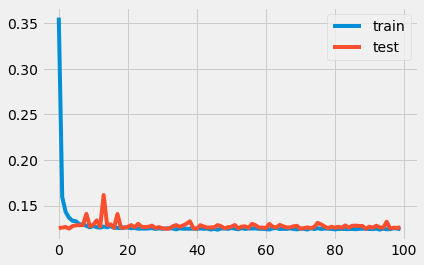

In [66]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(128, return_sequences= True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(BatchNormalization())
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss='Huber', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [67]:
import math
from sklearn.metrics import confusion_matrix

# TRAIN SET
yhat = model.predict(train_X)
y_pred = (yhat > 0.5)
cm = confusion_matrix(train_y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("TrainSet Accuracy %.2f%%" % acc)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(train_y, yhat))
print('Train RMSE: %.3f' % rmse)



# TEST SET
yhat = model.predict(test_X)
y_pred = (yhat > 0.5)
cm = confusion_matrix(test_y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("TestSet Accuracy %.2f%%" % acc)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)



TrainSet Accuracy 55.65%
Train RMSE: 0.496
TestSet Accuracy 53.46%
Test RMSE: 0.502


#Backtesting 

In [68]:
# split into input and outputs (last column is Y)
df = get_data(stock_ticker, 1)

df = df.reset_index()
date = pd.DataFrame(df['Date'], columns=['Date'])
df.drop('Date', inplace=True, axis=1)
values = df.values
# preprocess

reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[10,9,8,7,11,12]], axis=1, inplace=True)
values = reframed.values
values = values.astype('float32')

from sklearn import preprocessing

x = values[:,:-1]
y = values[:, -1]
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)
x = x.reshape((x.shape[0], 1, x.shape[1]))
x.shape


(2168, 1, 7)

In [69]:
import math
parameter = 0.5
# make a prediction
yhat = model.predict(x)
# store in Results DataFrame
results = pd.DataFrame(yhat, columns=['Result'])
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y, yhat))
print('RMSE: %.3f' % rmse)

y_pred = (yhat > parameter)
cm = confusion_matrix(y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("Accuracy %.2f%%" % acc)

#When predicted is > 0.5, buy at open. sell at close.
#Starting Capital $1000
#Results

capital = 1000

results['Open']=df['Open'] #0
results['Close'] = df['Close'] #1
results['LSTM'] = capital #2
results['Buy&Hold'] = capital #3
results['Date'] = date['Date']

for i in range(1,len(results)):
  if (results.iloc[i,0] < parameter):# if less than 0.5, do nothing and retain the previous day capital
    results.iloc[i, 3] = results.iloc[i-1,3] 
  else: # buy at open price with all capital and sell at close
    results.iloc[i, 3] = results.iloc[i-1, 3] / results.iloc[i, 1] * results.iloc[i, 2] 

number_of_shares = capital / results.iloc[0][1]

for i in range(1,len(results)):
  results.iloc[i,4] = number_of_shares * results.iloc[i,2]

profit = number_of_shares*results.iloc[-1][2] - capital


final_value = results.iloc[-1][3]
alpha = final_value-capital
print("========================================")
print("Initial Capital: $",capital)
print("========================================")
print("LSTM trading strategy Profits: $%.2f" % alpha)
print("Percentage Gain: %.2f%%" % (alpha/capital*100))
#Buy and Hold (Buy at Open price, Sell at Close Price)
print("========================================")
print("Profits from Buy and Hold $%.2f" % profit)
print("Percentage Gain: %.2f%%" % (profit/capital*100))
results

RMSE: 0.500
Accuracy 54.61%
Initial Capital: $ 1000
LSTM trading strategy Profits: $-868.91
Percentage Gain: -86.89%
Profits from Buy and Hold $6442.38
Percentage Gain: 644.24%


,Result,Open,Close,LSTM,Buy&Hold,Date
0,0.425606,36.529999,34.029999,1000.000000,1000.000000,2012-05-21
1,0.549596,32.610001,31.000000,950.628624,848.617603,2012-05-22
2,0.478260,31.370001,32.000000,950.628624,875.992364,2012-05-23
3,0.486401,32.950001,33.029999,950.628624,904.188335,2012-05-24
4,0.339035,32.900002,31.910000,950.628624,873.528632,2012-05-25
...,...,...,...,...,...,...
2163,0.527460,266.890015,268.109985,130.829597,7339.446874,2020-12-23
2164,0.595569,268.880005,267.399994,130.109464,7320.011027,2020-12-24
2165,0.529820,268.739990,277.000000,134.108517,7582.808904,2020-12-28
2166,0.586142,276.950012,276.779999,134.026191,7576.786423,2020-12-29


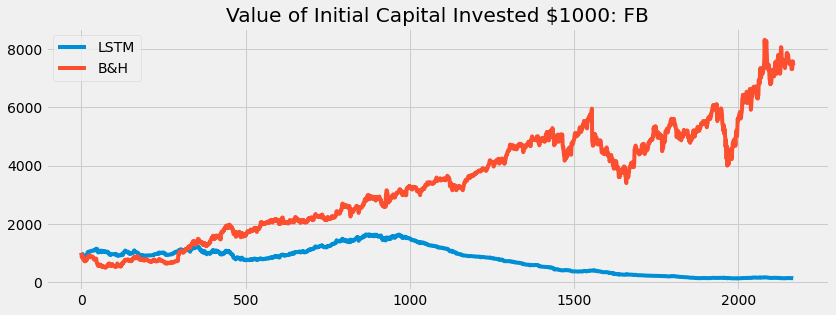

In [70]:
#Visualize Results
plt.figure(figsize=(12.5,4.5))
plt.plot(results['LSTM'], label='LSTM')
plt.plot(results['Buy&Hold'], label='B&H')
plt.title('Value of Initial Capital Invested $' + str(capital) +': ' +stock_ticker)


plt.legend()
plt.show()


In [71]:
if (alpha>profit):
  print("YES")
else:
  print("nope")

nope


#Test on 2021

In [72]:

# split into input and outputs (last column is Y)
df = get_data(stock_ticker, 0)

df = df.reset_index()
date = pd.DataFrame(df['Date'], columns=['Date'])
df.drop('Date', inplace=True, axis=1)
values = df.values
# preprocess

reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[10,9,8,7,11,12]], axis=1, inplace=True)
values = reframed.values
#values = values.astype('float32')

from sklearn import preprocessing

x = values[:,:-1]
y = values[:, -1]
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)
x = x.reshape((x.shape[0], 1, x.shape[1]))
x.shape



import math
# make a prediction
yhat = model.predict(x)
# store in Results DataFrame
results = pd.DataFrame(yhat, columns=['Result'])
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y, yhat))
print('RMSE: %.3f' % rmse)

y_pred = (yhat > parameter)
cm = confusion_matrix(y, y_pred)
acc = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print("Accuracy %.2f%%" % acc)

#When predicted is > parameter, buy at open. sell at close.
#Starting Capital $1000
#Results

capital = 1000

results['Open']=df['Open']
results['Close'] = df['Close']
results['LSTM'] = capital
results['Buy&Hold'] = capital
results['Date'] = date['Date']

for i in range(1,len(results)):
  if (results.iloc[i,0] < parameter):
    results.iloc[i, 3] = results.iloc[i-1,3] #if less than 0.5, do nothing and retain the previous day capital
  else:
    results.iloc[i, 3] = results.iloc[i-1, 3] / results.iloc[i, 1] * results.iloc[i, 2] #buy at open price with all capital and sell at close

number_of_shares = capital / results.iloc[0][1]

for i in range(1,len(results)):
  results.iloc[i,4] = number_of_shares * results.iloc[i,2]

profit = number_of_shares*results.iloc[-1][2] - capital


final_value = results.iloc[-1][3]
alpha = final_value-capital
print("========================================")
print("LSTM trading strategy Profits: $%.2f" % alpha)
print("Percentage Gain: %.2f%%" % (alpha/capital*100))
#Buy and Hold (Buy at Open price, Sell at Close Price)
print("========================================")
print("Profits from Buy and Hold $%.2f" % profit)
print("Percentage Gain: %.2f%%" % (profit/capital*100))



RMSE: 0.527
Accuracy 41.67%
LSTM trading strategy Profits: $25.18
Percentage Gain: 2.52%
Profits from Buy and Hold $97.80
Percentage Gain: 9.78%


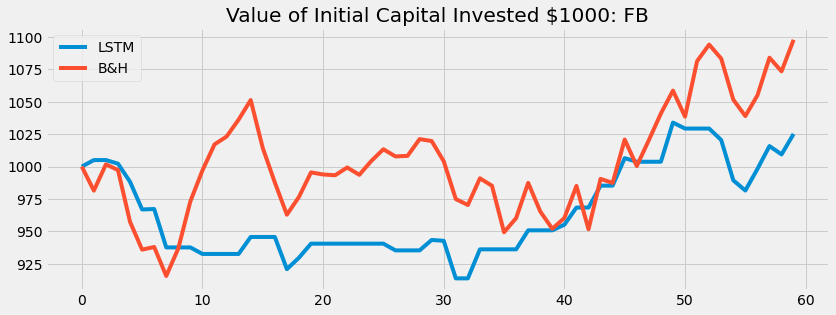

NOPE


In [73]:
#Visualize Results
plt.figure(figsize=(12.5,4.5))
plt.plot(results['LSTM'], label='LSTM')
plt.plot(results['Buy&Hold'], label='B&H')
plt.title('Value of Initial Capital Invested $' + str(capital) +': ' +stock_ticker)

plt.legend()
plt.show()

results.head()

if (alpha>profit):
  print("YES")
else:
  print("NOPE")

In [74]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
